In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Read the CSV
df = pd.read_csv("../results/ImageNet_disentanglement_regression_linear.csv")

/var/folders/22/gl3hkfn11y99h_1cyk_cn3fw0000gn/T/ipykernel_37443/214055137.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["intensity"] = intensities
/var/folders/22/gl3hkfn11y99h_1cyk_cn3fw0000gn/T/ipykernel_37443/214055137.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["intensity"] = intensities
/var/folders/22/gl3hkfn11y99h_1cyk_cn3fw0000gn/T/ipykernel_37443/214055137.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

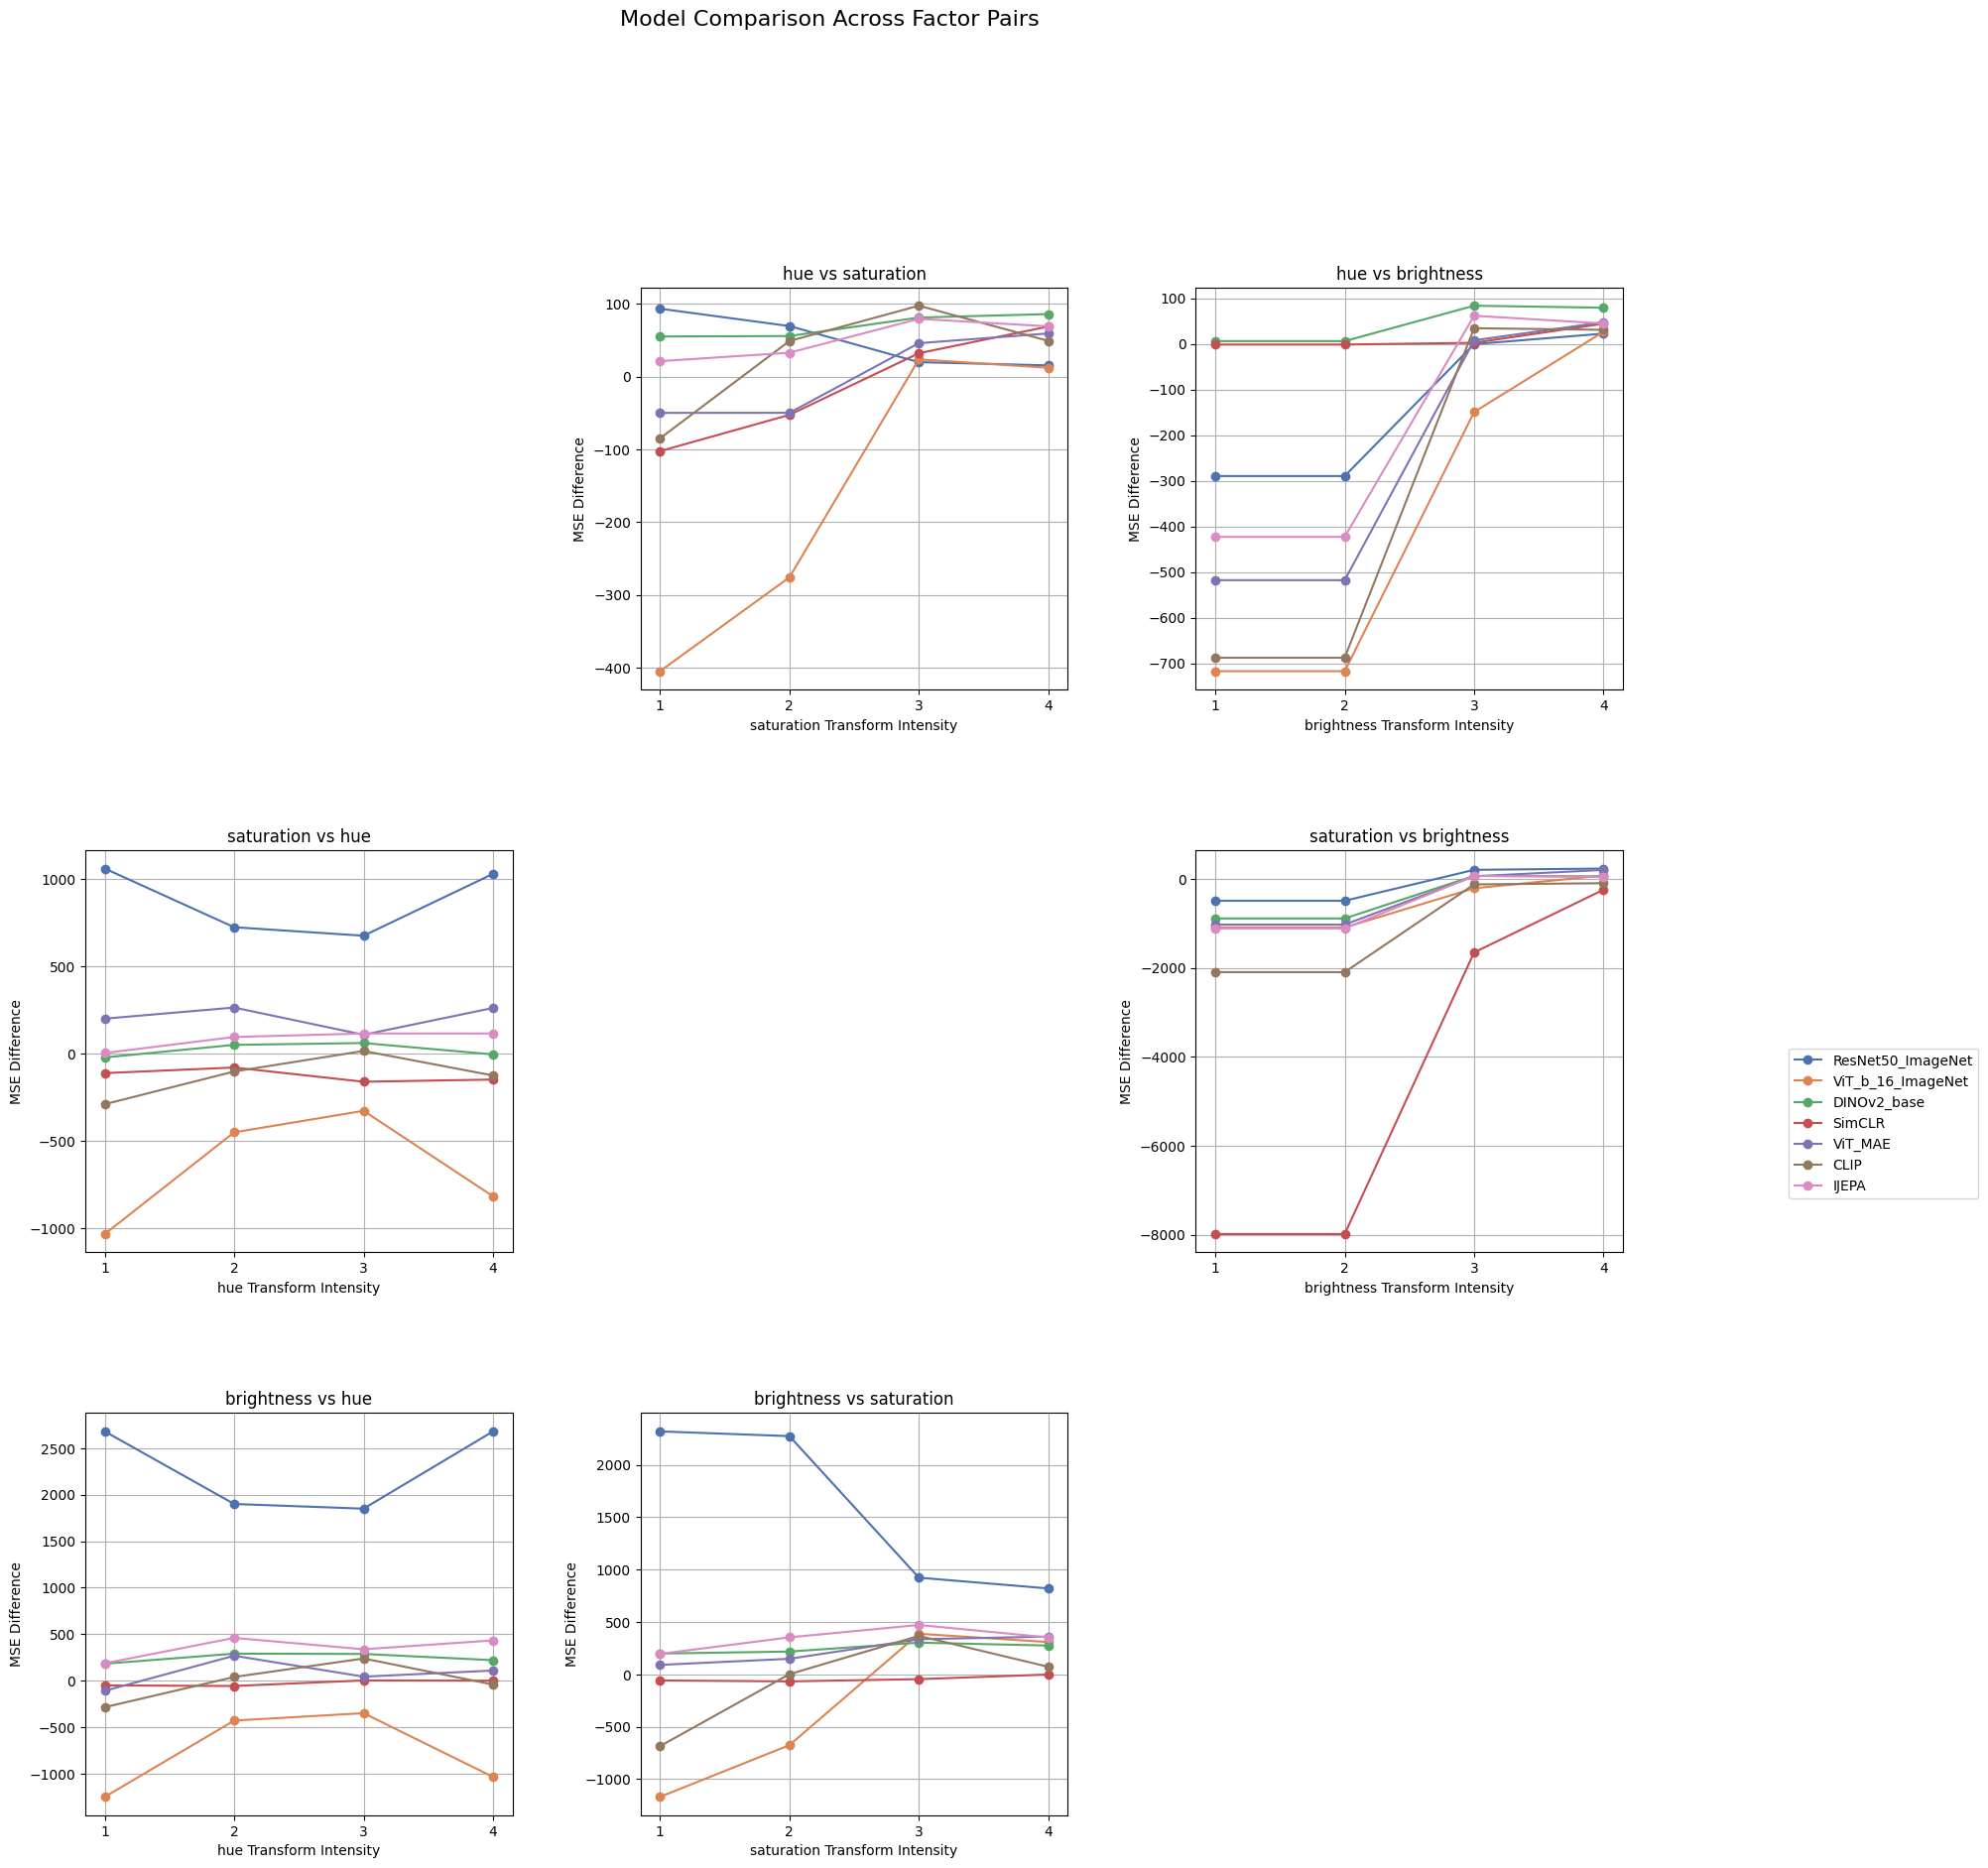

In [ ]:
def plot_model_comparisons(df):
    # Get unique models (strip _ImageNet suffix)
    models = [
        # "ResNet18_ImageNet",
        # "ResNet34_ImageNet",
        "ResNet50_ImageNet",
        # "ResNet101_ImageNet",
        "ViT_b_16_ImageNet",
        # "ViT_l_16_ImageNet",
        # "ViT_b_32_ImageNet",
        # "ViT_l_32_ImageNet",
        # "DINOv2_small",
        "DINOv2_base",
        # "DINOv2_large",
        # "DINO",
        "SimCLR",
        "ViT_MAE",
        "CLIP",
        "IJEPA",
    ]

    # Define factors
    factors = ["hue", "saturation", "brightness"]

    # Setup plot grid
    fig, axes = plt.subplots(3, 3, figsize=(20, 20))
    plt.subplots_adjust(hspace=0.4, wspace=0.3)

    # Colors for each model
    colors = sns.color_palette("deep", len(models))

    # Dictionary to store legend handles
    legend_elements = {}

    # Plot each factor combination
    for i, factor1 in enumerate(factors):
        for j, factor2 in enumerate(factors):
            if factor1 != factor2:
                ax = axes[i][j]

                # For each model
                for k, model in enumerate(models):
                    # Get data for this model and factor combination
                    model_data = df[df["run_name"].str.contains(model)]
                    transform = f"{factor2.capitalize()}Shift"
                    data = model_data[
                        (model_data["label"] == factor1)
                        & (model_data["transform"].str.contains(transform))
                    ]

                    # Extract intensities and sort
                    intensities = [
                        int(t.replace(transform, "")) for t in data["transform"]
                    ]
                    data["intensity"] = intensities
                    data = data.sort_values("intensity")

                    # Plot line
                    line = ax.plot(
                        ["[-100%, -50%]", "[-50%, 0%]", "[0%, 50%]", "[50%, 100%]"],
                        data["diff_mse"],
                        "o-",
                        color=colors[k],
                    )

                    # Only add to legend if first time seeing this model
                    if model not in legend_elements:
                        legend_elements[model] = line[0]

                ax.set_title(f"{factor1} vs {factor2}")
                ax.set_xlabel(f"{factor2} Transform Intensity")
                ax.set_ylabel("MSE Difference")
                ax.grid(True)

            else:
                # Clear diagonal plots
                axes[i][j].remove()

    # Add legend using unique handles
    fig.legend(
        legend_elements.values(),
        legend_elements.keys(),
        loc="upper left",
        bbox_to_anchor=(0.98, 0.5),
    )
    plt.suptitle("Model Comparison Across Factor Pairs", fontsize=16, y=1.02)
    plt.show()


plot_model_comparisons(df)